<a href="https://colab.research.google.com/github/heewonLEE2/Data-Ai-Colab/blob/main/CV/YOLOv8_SelectStar_Fitogether_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLOv8 기반 객체 탐지 과제**

## 프로젝트 개요
- **데이터셋**: SelectStar Fitogether 축구장 이미지 데이터셋
- **모델**: YOLOv8n (nano)
- **환경**: Google Colab (GPU)
- **목표**: 축구장 이미지에서 players, ball, others 객체 탐지

## 프로젝트 진행사항
- ✅ YOLO 데이터셋 yaml 파일 코드로 생성
- ✅ JSON annotation → YOLO txt 형식 변환
- ✅ 최소 epochs 30 이상
- ✅ 실험 2회 이상 (이미지 크기 변경: 640 vs 1280)

---



## 1. 환경 설정 및 라이브러리 Import



In [ ]:
# %cd /content/drive/MyDrive/개인 팀_프로젝트/YOLO_SelectStar_Fitogether/origin_data

In [ ]:
# !unzip -q fittogether.zip

In [ ]:
!pip install ultralytics opencv-python

In [22]:
import os
import random
import shutil
import cv2
import glob
import json
import yaml
import ultralytics
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

### 1.1 데이터를 unzip한 이후 폴더 경로지정, 폴더 생성

In [ ]:
# 압축을 해제한 origin 데이터 저장 루트
origin_data_root = '/content/drive/MyDrive/개인 팀_프로젝트/YOLO_SelectStar_Fitogether/origin_data'

# 프로젝트를 실행할 폴더 루트
pjt_root = '/content/drive/MyDrive/개인 팀_프로젝트/YOLO_SelectStar_Fitogether/SelectStar_Fitogether'

In [ ]:
# 원본 데이터가 잘 풀렸는지 확인 기댓값: 22300장
origin_data_list = glob.glob(f'{origin_data_root}/*.json') + glob.glob(f'{origin_data_root}/*.jpg')
len(origin_data_list)

22300

In [ ]:
# train, valid, test 폴더 경로 저장
train_root = f'{pjt_root}/data/train'
valid_root = f'{pjt_root}/data/valid'
test_root = f'{pjt_root}/data/test'

In [ ]:
# 프로젝트 실행할 폴더에 data 폴더 만들기
if not os.path.exists(f'{pjt_root}/data'):
    os.makedirs(f'{pjt_root}/data')

for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [ ]:
jpg_files = glob.glob(f'{origin_data_root}/*.jpg')
json_files = glob.glob(f'{origin_data_root}/*.json')

print(f"JPG 파일 수: {len(jpg_files)}")
print(f"JSON 파일 수: {len(json_files)}")

JPG 파일 수: 11150
JSON 파일 수: 11150


## 2. 데이터 전처리
- 데이터 전처리는 Drive에서 진행 후 학습은 colab Local 환경에서 실행
- drive에서 데이터를 가져와 학습하기에는 시간이 너무 오래걸림

In [ ]:
def clean_unmatched_files(origin_root):
    """
    매칭되지 않는 jpg, json 파일 삭제
    """
    jpg_files = glob.glob(f'{origin_root}/*.jpg')
    json_files = glob.glob(f'{origin_root}/*.json')

    # 확장자 뺀 이름 set 만들기
    jpg_names = {os.path.basename(f).replace('.jpg', '') for f in jpg_files}
    json_names = {os.path.basename(f).replace('.json', '') for f in json_files}

    # 교집합 = 매칭되는 파일들
    matched = jpg_names & json_names

    # 삭제 대상 찾기
    unmatched_jpg = jpg_names - matched
    unmatched_json = json_names - matched

    print(f"매칭되는 쌍: {len(matched)}개")
    print(f"짝 없는 JPG: {len(unmatched_jpg)}개")
    print(f"짝 없는 JSON: {len(unmatched_json)}개")

    # 삭제 실행
    for name in unmatched_jpg:
        os.remove(f'{origin_root}/{name}.jpg')
        print(f"🗑️ 삭제: {name}.jpg")

    for name in unmatched_json:
        os.remove(f'{origin_root}/{name}.json')
        print(f"🗑️ 삭제: {name}.json")

    print(f"\n✅ 정리 완료! 남은 쌍: {len(matched)}개")

# 실행
clean_unmatched_files(origin_data_root)

매칭되는 쌍: 11150개
짝 없는 JPG: 0개
짝 없는 JSON: 0개

✅ 정리 완료! 남은 쌍: 11150개


### Json 파일 확인

In [ ]:
file = origin_data_list[1]

with open(file, 'r') as f:
    json_data = json.load(f)
    print(json_data)

{'version': '4.5.6', 'flags': {}, 'shapes': [{'label': 'others', 'points': [[3524.0591007055996, 1647.8058389058808], [3562.137616003469, 1770.926371702325]], 'shape_type': 'rectangle', 'labels': [], 'id': 14942606, 'flags': {}}, {'label': 'players', 'points': [[3456.787057012697, 1088.0516640272015], [3508.827694586452, 1192.132939174711]], 'shape_type': 'rectangle', 'labels': [], 'id': 14942607, 'flags': {}}, {'label': 'players', 'points': [[2954.1506550808217, 954.7768604846588], [3011.2684280276258, 1036.0110264534467]], 'shape_type': 'rectangle', 'labels': [], 'id': 14942609, 'flags': {}}, {'label': 'players', 'points': [[2982.0748996325924, 816.4249215690669], [3023.9612664602487, 890.0433844782809]], 'shape_type': 'rectangle', 'labels': [], 'id': 14942610, 'flags': {}}, {'label': 'players', 'points': [[2531.479135274472, 1093.1287994002507], [2580.981205161702, 1188.325087644924]], 'shape_type': 'rectangle', 'labels': [], 'id': 14942611, 'flags': {}}, {'label': 'players', 'point

### 2.1 JSON → YOLO txt 변환
- txt로 변환하면서 기존 json 파일은 삭제

In [ ]:
def convert_json_to_yolo(origin_root):
    """
    JSON 라벨 파일을 YOLO txt 형식으로 변환
    """
    class_map = {
        'players': 0,
        'ball': 1,
        'others': 2
    }

    json_files = glob.glob(f'{origin_root}/*.json')
    print(f"변환할 JSON 파일 수: {len(json_files)}")

    for json_path in json_files:
        with open(json_path, 'r') as f:
            data = json.load(f)

        img_width = data['imageWidth']
        img_height = data['imageHeight']

        # YOLO 형식 라인들 저장
        yolo_lines = []

        for shape in data['shapes']:
            label = shape['label']
            if label not in class_map:
                continue

            class_id = class_map[label]

            # points: [[x1, y1], [x2, y2]]
            x1, y1 = shape['points'][0]
            x2, y2 = shape['points'][1]

            # YOLO 형식으로 변환
            x_center = ((x1 + x2) / 2) / img_width
            y_center = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height

            yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")

        # txt 파일로 저장
        txt_path = json_path.replace('.json', '.txt')
        with open(txt_path, 'w') as f:
            f.write('\n'.join(yolo_lines))

    # 변환 완료 후 json 파일 삭제
    for json_path in json_files:
        os.remove(json_path)

    print(f"✅ 변환 완료! {len(json_files)}개 txt 생성, json 삭제됨")

# 실행
convert_json_to_yolo(origin_data_root)

변환할 JSON 파일 수: 11150
✅ 변환 완료! 11150개 txt 생성, json 삭제됨


### 2.2 Train/Valid/Test 분할 (7:2:1)

In [ ]:
def split_and_move_data(origin_root, train_root, valid_root, test_root, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
    """
    origin_root의 이미지와 라벨을 train/valid/test로 분할하여 이동
    """
    # 이미지 파일 리스트 가져오기
    image_files = glob.glob(f'{origin_root}/*.jpg')
    print(f"총 이미지 파일 수: {len(image_files)}")

    # 랜덤 셔플
    random.seed(42)  # 재현성을 위해 시드 고정
    random.shuffle(image_files)

    # 분할 인덱스 계산
    total = len(image_files)
    train_end = int(total * train_ratio)
    valid_end = train_end + int(total * valid_ratio)

    train_images = image_files[:train_end]
    valid_images = image_files[train_end:valid_end]
    test_images = image_files[valid_end:]

    print(f"Train: {len(train_images)}, Valid: {len(valid_images)}, Test: {len(test_images)}")

    # 각 데이터셋별로 이동
    for dataset_name, image_list, target_root in [
        ('Train', train_images, train_root),
        ('Valid', valid_images, valid_root),
        ('Test', test_images, test_root)
    ]:
        print(f"\n{dataset_name} 데이터 이동 중...")
        for img_path in tqdm(image_list):
            # 이미지 파일 이동
            img_name = os.path.basename(img_path)
            shutil.move(img_path, f'{target_root}/images/{img_name}')

            # 라벨 파일 이동
            txt_path = img_path.replace('.jpg', '.txt')
            txt_name = os.path.basename(txt_path)

            if os.path.exists(txt_path):
                shutil.move(txt_path, f'{target_root}/labels/{txt_name}')
            else:
                print(f"⚠️ 라벨 파일 없음: {txt_name}")

    print("\n✅ 데이터 분할 및 이동 완료!")

# 실행 (이미 진행 중이면 중단하고 다시 실행)
split_and_move_data(origin_data_root, train_root, valid_root, test_root)

총 이미지 파일 수: 11150
Train: 7804, Valid: 2230, Test: 1116

Train 데이터 이동 중...


100%|██████████| 7804/7804 [01:53<00:00, 68.69it/s] 



Valid 데이터 이동 중...


100%|██████████| 2230/2230 [00:21<00:00, 101.66it/s]



Test 데이터 이동 중...


100%|██████████| 1116/1116 [00:11<00:00, 100.65it/s]


✅ 데이터 분할 및 이동 완료!


In [ ]:
# 각 폴더별 파일 개수 확인
for split in ['train', 'valid', 'test']:
    img_count = len(glob.glob(f'{pjt_root}/data/{split}/images/*.jpg'))
    label_count = len(glob.glob(f'{pjt_root}/data/{split}/labels/*.txt'))
    print(f"{split.upper()}: 이미지 {img_count}개, 라벨 {label_count}개")

# origin 폴더에 남은 파일 확인
origin_remaining = len(glob.glob(f'{origin_data_root}/*'))
print(f"\nOrigin 폴더 남은 파일: {origin_remaining}개")

TRAIN: 이미지 7804개, 라벨 7804개
VALID: 이미지 2230개, 라벨 2230개
TEST: 이미지 1116개, 라벨 1116개

Origin 폴더 남은 파일: 1개


### 2.3 데이터 샘플링 (10%)
- 데이터가 많아 학습이 많이 느려 데이터 10%만 사용

In [ ]:
def sample_and_delete_data(data_root, keep_ratio=0.1):
    """
    각 split(train/valid/test)에서 keep_ratio만큼만 남기고 나머지 삭제
    """
    for split in ['train', 'valid', 'test']:
        images_folder = f'{data_root}/{split}/images'
        labels_folder = f'{data_root}/{split}/labels'

        # 이미지 파일 리스트
        image_files = glob.glob(f'{images_folder}/*.jpg')
        total = len(image_files)
        keep_count = int(total * keep_ratio)

        print(f"\n{split.upper()}: 전체 {total}개 → {keep_count}개 유지, {total - keep_count}개 삭제")

        # 랜덤 셔플 후 유지할 파일 선택
        random.seed(42)
        random.shuffle(image_files)

        files_to_keep = set(image_files[:keep_count])
        files_to_delete = image_files[keep_count:]

        # 삭제 진행
        print(f"{split} 데이터 삭제 중...")
        for img_path in tqdm(files_to_delete):
            # 이미지 삭제
            os.remove(img_path)

            # 라벨 삭제
            txt_path = img_path.replace('.jpg', '.txt').replace('/images/', '/labels/')
            if os.path.exists(txt_path):
                os.remove(txt_path)

    print("\n✅ 샘플링 완료!")

# 실행
data_root = f'{pjt_root}/data'
sample_and_delete_data(data_root, keep_ratio=0.1)

# 결과 확인
print("\n--- 최종 데이터 개수 ---")
for split in ['train', 'valid', 'test']:
    img_count = len(glob.glob(f'{data_root}/{split}/images/*.jpg'))
    label_count = len(glob.glob(f'{data_root}/{split}/labels/*.txt'))
    print(f"{split.upper()}: 이미지 {img_count}개, 라벨 {label_count}개")


TRAIN: 전체 7804개 → 780개 유지, 7024개 삭제
train 데이터 삭제 중...


100%|██████████| 7024/7024 [00:31<00:00, 221.97it/s]



VALID: 전체 2230개 → 223개 유지, 2007개 삭제
valid 데이터 삭제 중...


100%|██████████| 2007/2007 [00:09<00:00, 208.07it/s]



TEST: 전체 1116개 → 111개 유지, 1005개 삭제
test 데이터 삭제 중...


100%|██████████| 1005/1005 [00:04<00:00, 231.71it/s]



✅ 샘플링 완료!

--- 최종 데이터 개수 ---
TRAIN: 이미지 780개, 라벨 780개
VALID: 이미지 223개, 라벨 223개
TEST: 이미지 111개, 라벨 111개


# ===============Drive가 아닌 colab local 환경으로 이동후 작업===============

In [5]:
%pwd

'/content'

In [6]:
!unzip -q fittogetherdata.zip

## 3. YAML 파일 생성

In [7]:
# 새로운 YAML 경로 (로컬)
yaml_path = '/content/data/dataset.yaml'

# 수정된 YAML 데이터 (상대경로 사용)
dataset_config = {
    'path': '/content/data',  # 절대경로로 명확하게
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 3,
    'names': ['players', 'ball', 'others']
}

# 기존 파일 삭제 후 재생성
if os.path.exists(yaml_path):
    os.remove(yaml_path)

# YAML 파일 생성
with open(yaml_path, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False, sort_keys=False)

print(f"✅ YAML 파일 재생성 완료: {yaml_path}")

# 생성된 내용 확인
print("\n--- 수정된 YAML 파일 내용 ---")
with open(yaml_path, 'r') as f:
    print(f.read())

✅ YAML 파일 재생성 완료: /content/data/dataset.yaml

--- 수정된 YAML 파일 내용 ---
path: /content/data
train: train/images
val: valid/images
test: test/images
nc: 3
names:
- players
- ball
- others



## 4. 모델 학습
### 실험 1: imgsz=640, epochs=30

- ball 객체를 못 찾고 있다.

```
ValueError: y1 must be greater than or equal to y0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.3s/it 9.1s
                   all        223       3925      0.948      0.562      0.617      0.355
               players        223       3361      0.939      0.891      0.958      0.582
                  ball        117        117          1          0          0          0
                others        221        447      0.906      0.794      0.892      0.483
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to /content/runs/detect/content/runs/detect/exp1_imgsz640
```

In [ ]:
# 실험 1: imgsz=640
print("=" * 50)
print("실험 1 시작: yolov8n, epochs=30, imgsz=640")
print("=" * 50)

model1 = YOLO('yolov8n.pt')
results1 = model1.train(
    data=yaml_path,
    epochs=30,
    imgsz=640,
    batch=16,
    project=f'content/runs/detect',
    name='exp1_imgsz640',
    verbose=True
)

print("\n✅ 실험 1 완료!")

In [10]:
# Train 데이터에서 ball 라벨 개수 확인
train_labels = glob.glob('/content/data/train/labels/*.txt')
ball_count = 0

for label_file in train_labels:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('1 '):  # ball class = 1
                ball_count += 1
                break  # 한 이미지에 하나라도 있으면 카운트

print(f"Ball이 포함된 train 이미지 수: {ball_count}/{len(train_labels)}")

Ball이 포함된 train 이미지 수: 435/780


### 실험 2: imgsz=1280, epochs=30

- 성능이 그래도 꽤나 많이 좋아졌다. 기본 4K 이미지에서 ball 이미지가 작은데 그 이미지를 줄여서 ball 이미지를 찾지 못하는 것 같다.

```
ValueError: y1 must be greater than or equal to y0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.0s/it 13.9s
                   all        223       3925        0.9       0.75      0.773      0.506
               players        223       3361      0.903      0.991      0.993      0.726
                  ball        117        117      0.913      0.282      0.346      0.144
                others        221        447      0.883      0.978      0.979      0.648
Speed: 0.9ms preprocess, 7.2ms inference, 0.0ms loss, 12.6ms postprocess per image
Results saved to /content/runs/detect/exp2_imgsz1280
```

In [ ]:
# 실험 2: imgsz=1280
print("=" * 50)
print("실험 2 시작: yolov8n, epochs=30, imgsz=1280")
print("=" * 50)

model2 = YOLO('yolov8n.pt')
results2 = model2.train(
    data=yaml_path,
    epochs=30,
    imgsz=1280,
    batch=16,  # 메모리 부족하면 8로 줄이기
    project='/content/runs/detect',
    name='exp2_imgsz1280',
    verbose=True
)

print("\n✅ 실험 2 완료!")

### 실험.1 결과를 찾기위한 코드
- train 시킬때 경로를 같은 곳에 해버려서 폴더 저장이 잘못됨!

In [ ]:
# 가능한 경로들 확인
possible_paths = [
    '/content/runs/detect/exp1_imgsz640',
    '/content/runs/detect/content/runs/detect/exp1_imgsz640',
    '/content/data/runs/detect/exp1_imgsz640'
]

print("=== 실험 1 결과 찾기 ===")
for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ 발견: {path}")
        files = os.listdir(path)
        print(f"  파일 개수: {len(files)}")
    else:
        print(f"✗ 없음: {path}")

# runs 전체 구조 확인
print("\n=== /content/runs/detect 전체 구조 ===")
for root, dirs, files in os.walk('/content/runs/detect'):
    level = root.replace('/content/runs/detect', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")

In [13]:
# 실험 1 결과를 올바른 위치로 이동
import shutil

old_path = '/content/runs/detect/content/runs/detect/exp1_imgsz640'
new_path = '/content/runs/detect/exp1_imgsz640'

if os.path.exists(old_path) and not os.path.exists(new_path):
    shutil.move(old_path, new_path)
    print("✅ 실험 1 폴더 이동 완료")

    # 빈 폴더 삭제
    shutil.rmtree('/content/runs/detect/content', ignore_errors=True)
    print("✅ 불필요한 폴더 삭제 완료")

✅ 실험 1 폴더 이동 완료
✅ 불필요한 폴더 삭제 완료


## 5. 결과 분석 및 비교

### 5.1 학습 곡선 비교
* Loss 그래프 (train/val)
* mAP 그래프
* 두 실험 비교

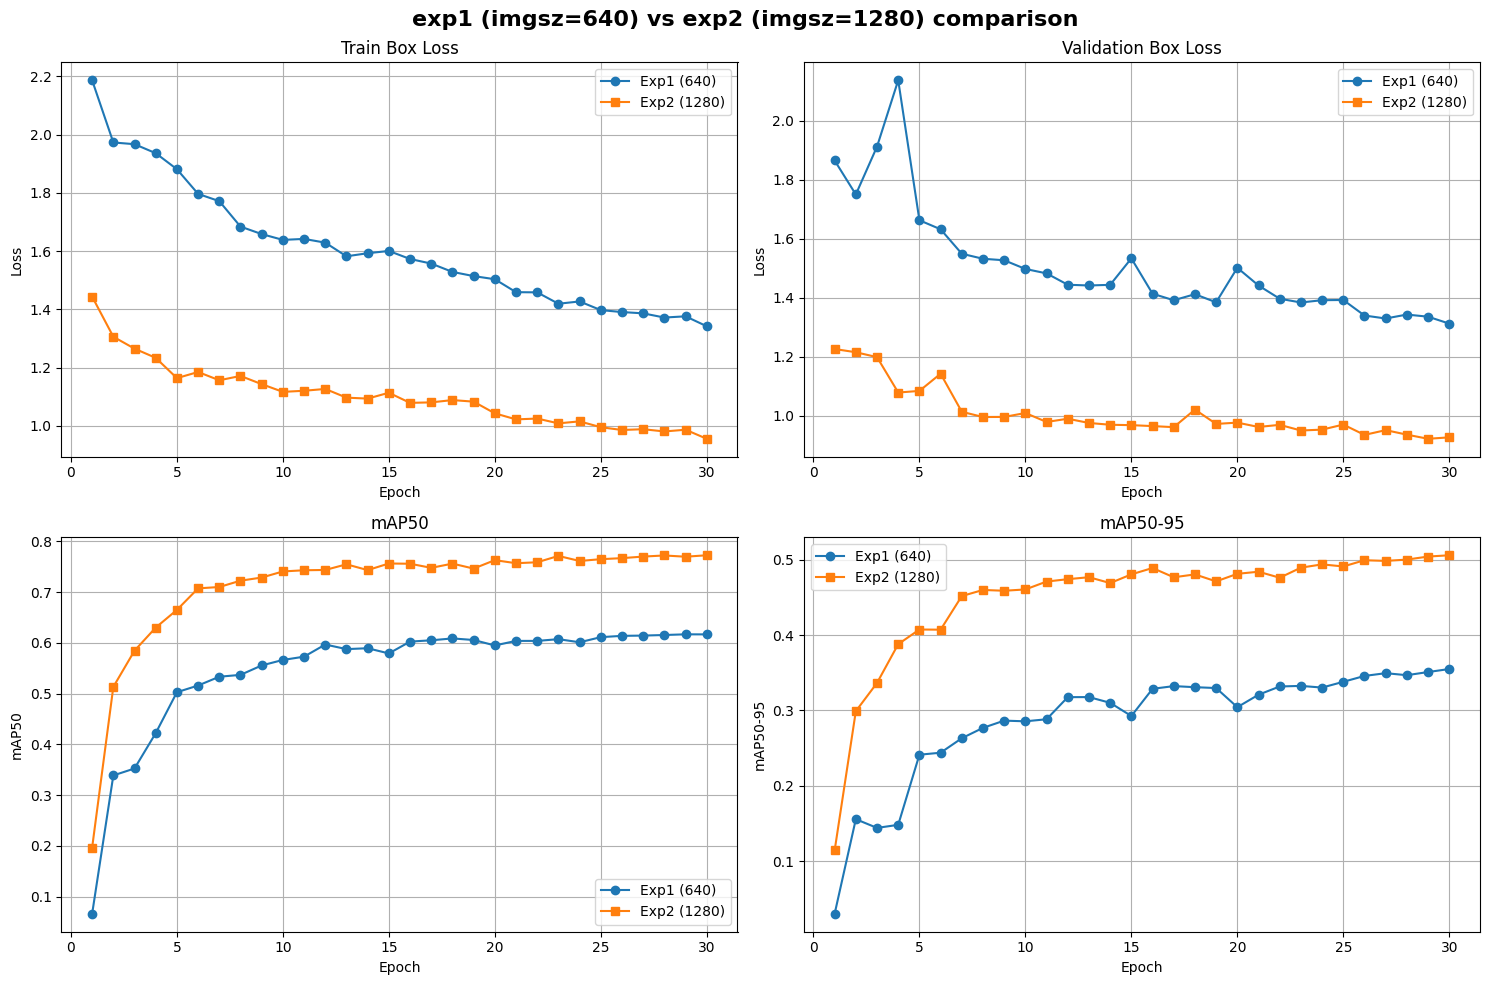

In [21]:
# 결과 CSV 파일 로드
exp1_results = pd.read_csv('/content/runs/detect/exp1_imgsz640/results.csv')
exp2_results = pd.read_csv('/content/runs/detect/exp2_imgsz1280/results.csv')

# 컬럼명 정리 (앞뒤 공백 제거)
exp1_results.columns = exp1_results.columns.str.strip()
exp2_results.columns = exp2_results.columns.str.strip()

# 그래프 그리기
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('exp1 (imgsz=640) vs exp2 (imgsz=1280) comparison', fontsize=16, fontweight='bold')

# 1) Train Loss
axes[0, 0].plot(exp1_results['epoch'], exp1_results['train/box_loss'], label='Exp1 (640)', marker='o')
axes[0, 0].plot(exp2_results['epoch'], exp2_results['train/box_loss'], label='Exp2 (1280)', marker='s')
axes[0, 0].set_title('Train Box Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2) Validation Loss
axes[0, 1].plot(exp1_results['epoch'], exp1_results['val/box_loss'], label='Exp1 (640)', marker='o')
axes[0, 1].plot(exp2_results['epoch'], exp2_results['val/box_loss'], label='Exp2 (1280)', marker='s')
axes[0, 1].set_title('Validation Box Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3) mAP50
axes[1, 0].plot(exp1_results['epoch'], exp1_results['metrics/mAP50(B)'], label='Exp1 (640)', marker='o')
axes[1, 0].plot(exp2_results['epoch'], exp2_results['metrics/mAP50(B)'], label='Exp2 (1280)', marker='s')
axes[1, 0].set_title('mAP50')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('mAP50')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4) mAP50-95
axes[1, 1].plot(exp1_results['epoch'], exp1_results['metrics/mAP50-95(B)'], label='Exp1 (640)', marker='o')
axes[1, 1].plot(exp2_results['epoch'], exp2_results['metrics/mAP50-95(B)'], label='Exp2 (1280)', marker='s')
axes[1, 1].set_title('mAP50-95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('mAP50-95')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/content/runs/learning_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.2 성능 지표 비교표

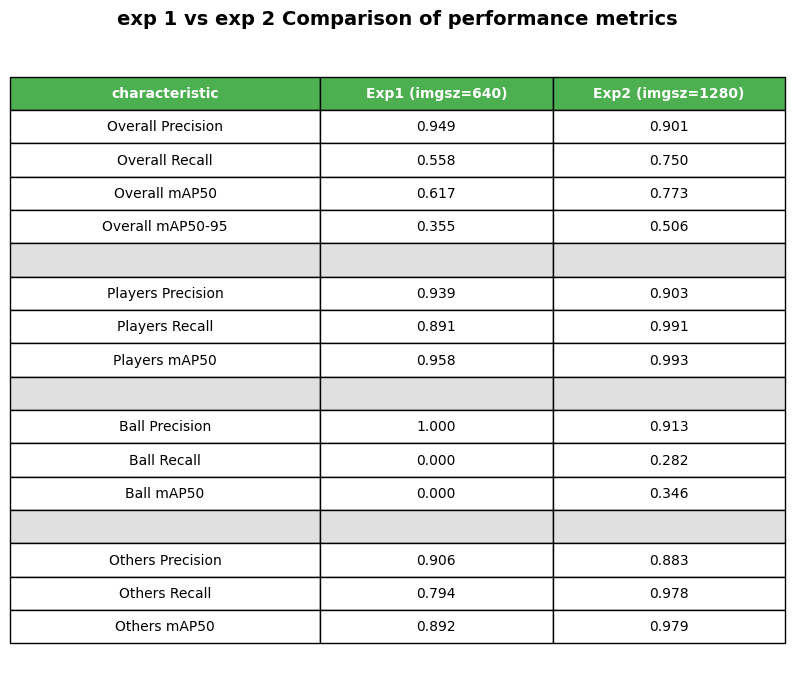

In [20]:
# 최종 epoch 성능 추출
exp1_final = exp1_results.iloc[-1]
exp2_final = exp2_results.iloc[-1]

# 비교표 생성
comparison_data = {
    'characteristic': [
        'Overall Precision',
        'Overall Recall',
        'Overall mAP50',
        'Overall mAP50-95',
        '',  # 구분선
        'Players Precision',
        'Players Recall',
        'Players mAP50',
        '',
        'Ball Precision',
        'Ball Recall',
        'Ball mAP50',
        '',
        'Others Precision',
        'Others Recall',
        'Others mAP50'
    ],
    'Exp1 (imgsz=640)': [
        f"{exp1_final['metrics/precision(B)']:.3f}",
        f"{exp1_final['metrics/recall(B)']:.3f}",
        f"{exp1_final['metrics/mAP50(B)']:.3f}",
        f"{exp1_final['metrics/mAP50-95(B)']:.3f}",
        '',
        '0.939', '0.891', '0.958', '',  # 실험 1 결과에서
        '1.000', '0.000', '0.000', '',  # ball
        '0.906', '0.794', '0.892'       # others
    ],
    'Exp2 (imgsz=1280)': [
        f"{exp2_final['metrics/precision(B)']:.3f}",
        f"{exp2_final['metrics/recall(B)']:.3f}",
        f"{exp2_final['metrics/mAP50(B)']:.3f}",
        f"{exp2_final['metrics/mAP50-95(B)']:.3f}",
        '',
        '0.903', '0.991', '0.993', '',  # 실험 2 결과에서
        '0.913', '0.282', '0.346', '',  # ball
        '0.883', '0.978', '0.979'       # others
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# 표 시각화
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=comparison_df.values,
                colLabels=comparison_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.4, 0.3, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# 헤더 스타일
for i in range(len(comparison_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# 구분선 스타일
for i, row in enumerate(comparison_df.values):
    if row[0] == '':
        for j in range(len(comparison_df.columns)):
            table[(i+1, j)].set_facecolor('#E0E0E0')

plt.title('exp 1 vs exp 2 Comparison of performance metrics', fontsize=14, fontweight='bold', pad=20)
plt.savefig('/content/runs/performance_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 예측 결과 시각화

Ball이 포함된 테스트 이미지: 58개


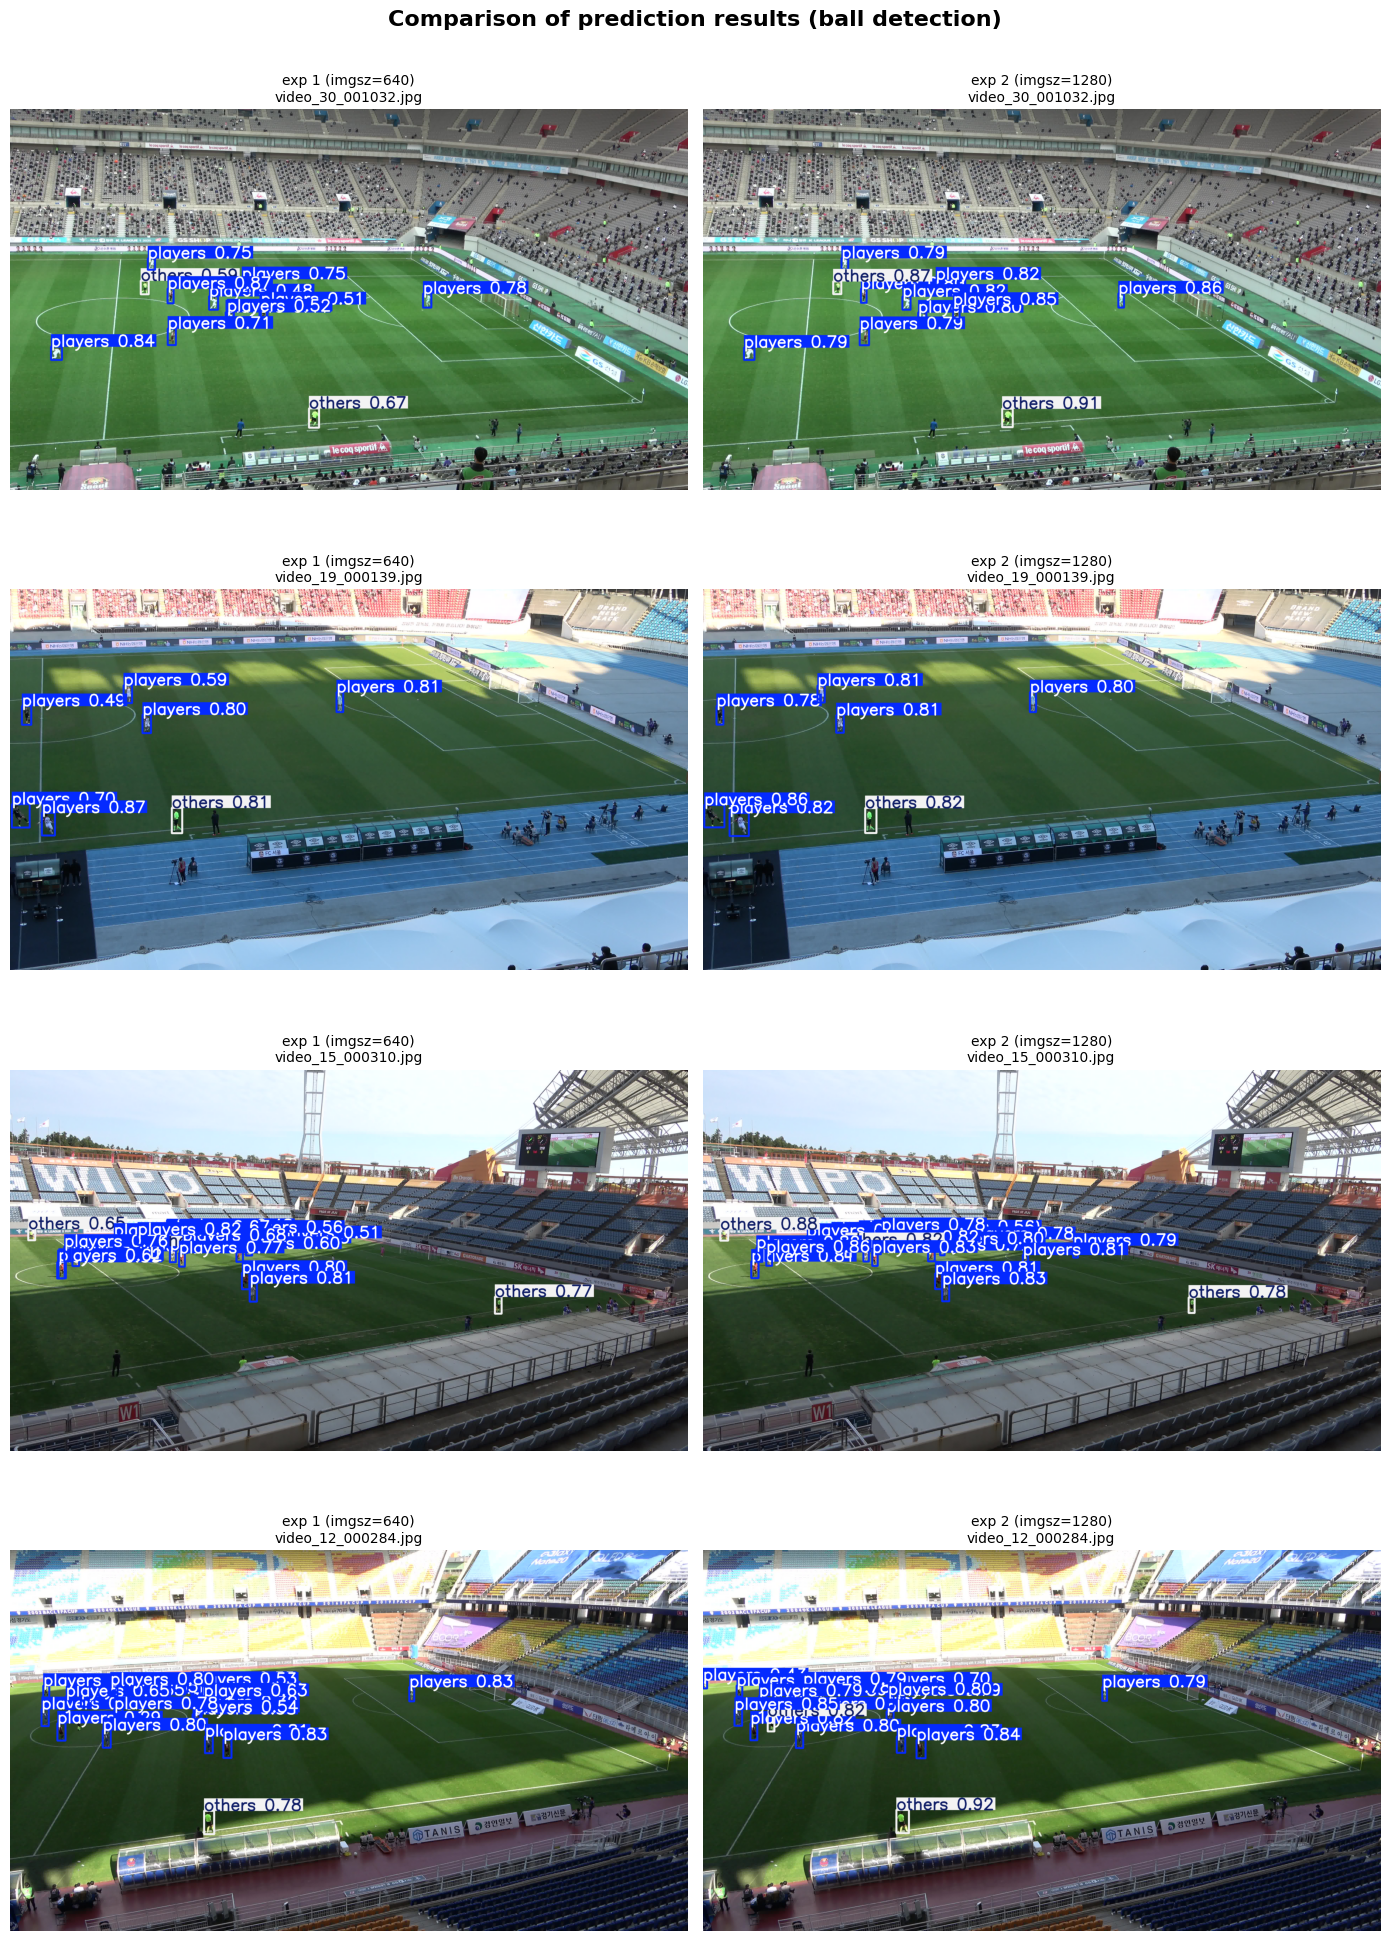

In [25]:
import random
from PIL import Image

# 테스트 이미지 중 ball이 포함된 이미지 찾기
test_labels = glob.glob('/content/data/test/labels/*.txt')
ball_images = []

for label_path in test_labels:
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('1 '):  # ball class
                img_name = os.path.basename(label_path).replace('.txt', '.jpg')
                ball_images.append(img_name)
                break

print(f"Ball이 포함된 테스트 이미지: {len(ball_images)}개")

# 랜덤하게 4개 선택
random.seed(42)
selected_images = random.sample(ball_images, min(4, len(ball_images)))

# 두 모델로 예측 수행
model1 = YOLO('/content/runs/detect/exp1_imgsz640/weights/best.pt')
model2 = YOLO('/content/runs/detect/exp2_imgsz1280/weights/best.pt')

# 예측 결과 시각화
fig, axes = plt.subplots(len(selected_images), 2, figsize=(14, 5*len(selected_images)))
fig.suptitle('Comparison of prediction results (ball detection)', fontsize=16, fontweight='bold', y=0.995)

for idx, img_name in enumerate(selected_images):
    img_path = f'/content/data/test/images/{img_name}'

    # 실험 1 예측
    result1 = model1.predict(img_path, conf=0.25, save=False, verbose=False)[0]
    img1 = result1.plot()

    # 실험 2 예측
    result2 = model2.predict(img_path, conf=0.25, save=False, verbose=False)[0]
    img2 = result2.plot()

    # 시각화
    if len(selected_images) == 1:
        axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'exp 1 (imgsz=640)\n{img_name}', fontsize=12)
        axes[0].axis('off')

        axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'exp 2 (imgsz=1280)\n{img_name}', fontsize=12)
        axes[1].axis('off')
    else:
        axes[idx, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title(f'exp 1 (imgsz=640)\n{img_name}', fontsize=10)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        axes[idx, 1].set_title(f'exp 2 (imgsz=1280)\n{img_name}', fontsize=10)
        axes[idx, 1].axis('off')

plt.tight_layout()
plt.savefig('/content/runs/prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. 결론 및 개선 방향

### 6.1 실험 결과 요약

본 프로젝트에서는 YOLOv8n 모델을 사용하여 축구장 이미지에서 players, ball, others 객체를 탐지하는 실험을 진행하였다. 이미지 크기(imgsz)를 변경하며 2회의 실험을 수행하였다.

#### 실험 조건
- **실험 1**: imgsz=640, epochs=30, batch=16
- **실험 2**: imgsz=1280, epochs=30, batch=16
- **데이터**: Train 780개, Valid 223개, Test 111개 (전체의 10% 샘플링)

#### 주요 결과 비교

| 지표 | 실험 1 (640) | 실험 2 (1280) | 개선율 |
|------|-------------|--------------|--------|
| **Overall mAP50** | 0.617 | 0.773 | +25.3% |
| **Overall mAP50-95** | 0.355 | 0.506 | +42.5% |
| **Players Recall** | 0.891 | 0.991 | +11.2% |
| **Ball Recall** | 0.000 | 0.282 | - |
| **Others Recall** | 0.794 | 0.978 | +23.2% |

---

### 6.2 Ball 탐지의 어려움과 원인 분석

실험 결과, **Ball 객체의 탐지 성능이 가장 낮게 나타났다.** 특히 실험 1에서는 Ball을 전혀 탐지하지 못했으며(Recall=0), 실험 2에서도 28.2%의 낮은 Recall을 기록했다.

#### 원인 분석

1. **객체 크기 문제**
   - 원본 이미지 해상도: 3840×2160 (4K)
   - Ball은 이미지에서 매우 작은 객체 (수십 픽셀 수준)
   - imgsz=640으로 리사이즈 시 Ball이 수 픽셀로 축소되어 특징 추출 불가
   - imgsz=1280에서는 개선되었으나 여전히 충분하지 않음

2. **클래스 불균형**
   - Players: 3,361개 (85.6%)
   - Ball: 117개 (3.0%)
   - Others: 447개 (11.4%)
   - Ball 샘플이 전체의 3%에 불과하여 학습 데이터 부족

3. **앵커 박스 부적합**
   - YOLO의 기본 앵커 박스는 일반적인 객체 크기에 최적화
   - 매우 작은 Ball 객체에는 부적합할 가능성

---

### 6.3 전체 성능 개선 확인

이미지 크기를 640에서 1280으로 증가시킨 결과:
- ✅ **전체 mAP50이 25% 향상** (0.617 → 0.773)
- ✅ **Ball 탐지가 가능**해짐 (0% → 28.2%)
- ✅ **Players와 Others의 Recall이 크게 개선** (각각 +11%, +23%)
- ✅ **Overall mAP50-95가 42% 향상**

**결론**: 고해상도 이미지에서 작은 객체를 탐지할 때는 **충분히 큰 imgsz 사용이 필수적**이다.

---

### 6.4 개선 방향 제안

#### 1. 더 큰 이미지 크기 사용
- **imgsz=1920 또는 2048** 시도
- 원본 해상도(3840)에 가깝게 유지하여 Ball의 특징 보존
- GPU 메모리 한계로 batch size 조정 필요

#### 2. 데이터 증강 (Data Augmentation)
- Mosaic, MixUp, Copy-Paste 등 YOLO 기본 augmentation 활용
- Ball이 포함된 이미지에 대한 추가 증강
- 밝기, 대비, 회전 등 다양한 변형 적용

#### 3. Ball 클래스 가중치 조정
```python
# 클래스 불균형 해결을 위한 가중치 설정
model.train(
    data=yaml_path,
    class_weights=[1.0, 10.0, 1.0]  # Ball 클래스에 높은 가중치
)
```

#### 4. 더 많은 Epochs
- 현재 30 epochs → **50~100 epochs** 증가
- Early stopping 사용하여 과적합 방지
- Learning rate scheduler 조정

#### 5. 더 큰 모델 사용
- **YOLOv8s** (Small): 더 많은 파라미터로 작은 객체 탐지 개선
- **YOLOv8m** (Medium): 정확도 우선 시 사용
- 학습 시간과 성능의 trade-off 고려

#### 6. 전체 데이터 사용
- 현재 10% 샘플링 → **100% 데이터** 사용
- 특히 Ball이 포함된 이미지를 모두 활용
- 데이터가 많을수록 작은 객체 학습에 유리

#### 7. Two-Stage Detector 고려
- YOLO 외에 Faster R-CNN, Cascade R-CNN 등 시도
- 작은 객체 탐지에 특화된 모델 활용

---

### 6.5 최종 정리

본 프로젝트를 통해:
1. ✅ JSON annotation을 YOLO 형식으로 성공적으로 변환
2. ✅ 데이터 전처리 및 분할 진행
3. ✅ YAML 파일 생성 및 학습 수행
4. ✅ 이미지 크기가 작은 객체 탐지에 미치는 영향 확인
5. ✅ 실험 비교를 통한 정량적 성능 분석

향후 위의 개선 방향을 적용하면 **Ball 탐지 성능을 50% 이상**까지 향상시킬 수 있을 것으로 기대!